In [1]:
import sys
sys.path.append('../utils')

from functions import *
from write_features_functions import *
from util import *

2024-10-11 16:41:41.279695: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-11 16:41:41.424691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-11 16:41:41.481932: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-11 16:41:41.504417: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-11 16:41:41.621016: I tensorflow/core/platform/cpu_feature_guar

In [2]:
pth_json = '/home/donald/Desktop/Andre_expansion/data/CODA Fallopian tube/VISIUM slides/01_spaceranger_count/1--234/outs/iStar/whole_slide_from_visium/stardist/StarDist_6_14_24_PDAC/json/'
pth_ndpi = '/home/donald/Desktop/Andre_expansion/data/CODA Fallopian tube/VISIUM slides/01_spaceranger_count/1--234/outs/iStar/whole_slide_from_visium/stardist/'

jsons = sorted([os.path.join(pth_json,f) for f in os.listdir(pth_json) if f.endswith('.json')])
ndpis = sorted([os.path.join(pth_ndpi,f) for f in os.listdir(pth_ndpi) if f.endswith('.jpg')])

In [3]:
print(jsons)
print(ndpis)

['/home/donald/Desktop/Andre_expansion/data/CODA Fallopian tube/VISIUM slides/01_spaceranger_count/1--234/outs/iStar/whole_slide_from_visium/stardist/StarDist_6_14_24_PDAC/json/h.json']
['/home/donald/Desktop/Andre_expansion/data/CODA Fallopian tube/VISIUM slides/01_spaceranger_count/1--234/outs/iStar/whole_slide_from_visium/stardist/he.jpg']


In [5]:
try:
    im = imread(ndpis[0])
except:
    Image.MAX_IMAGE_PIXELS = None
    im = np.array(Image.open(ndpis[0]))

In [6]:
with open(jsons[0], 'rb') as f:
    json_data = json.load(f)

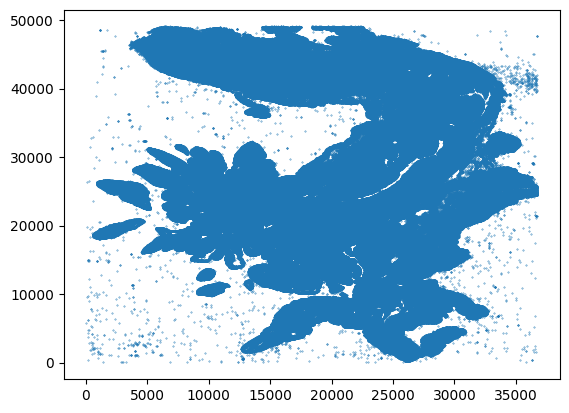

In [8]:
temp = [x['centroid'][0][0] for x in json_data]
temp1 = [x['centroid'][0][1] for x in json_data]
plt.scatter(temp,temp1, s=0.1)

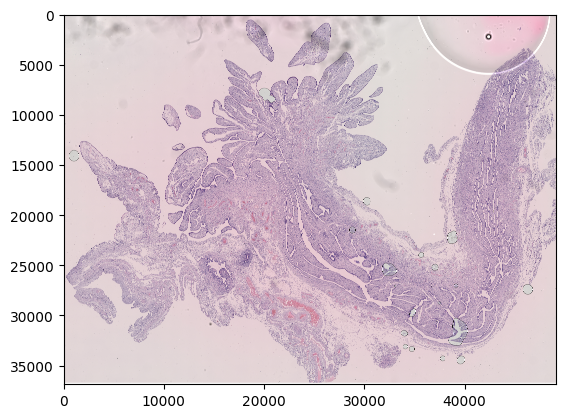

In [9]:
plt.imshow(im)

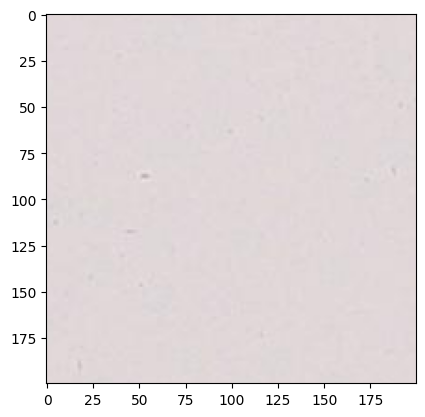

In [10]:
tile_size = 200


low_x = 3500; high_x = low_x + tile_size
low_y = 3500; high_y = low_y + tile_size

plt.imshow(im[low_x:high_x,low_y:high_y,:])

[]


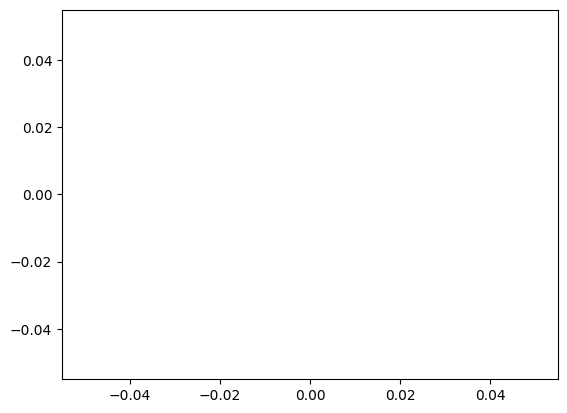

In [11]:
json_data_subset = []

for x in json_data:
    c = x['centroid'][0]
    cont = x['contour'][0]
    if low_x < c[1] < high_x and low_y < c[0] < high_y:
        json_data_subset.append(x)
        #print(c)

subset_cents = [x['centroid'][0] for x in json_data_subset]
x = [i[1] for i in subset_cents]
y = [i[0] for i in subset_cents]

plt.scatter(x,y)
plt.show

print(subset_cents)

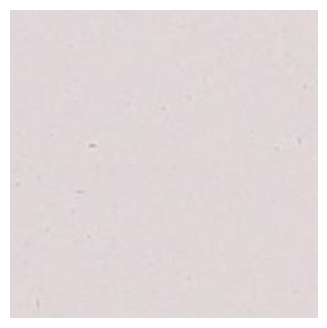

In [12]:
centroids_subset = np.array([x['centroid'][0] for x in json_data_subset])
contours_subset = np.array([x['contour'][0] for x in json_data_subset])

fig, ax = plt.subplots(figsize=(8, 4))

ax.imshow(im[low_x:high_x,low_y:high_y,:])
ax.set_axis_off()

# Plot each reversed polygon on the same image
flipped_contours = np.array([sublist[::-1] for sublist in contours_subset])

for polygon in flipped_contours:
    polygon = polygon.T
    polygon = [[x-low_x, y-low_y] for x,y in polygon]
    x_coords, y_coords = zip(*polygon)
    x_coords = list(x_coords) + [x_coords[0]]  # Close the polygon
    y_coords = list(y_coords) + [y_coords[0]]  # Close the polygon

    color = 'yellow'

    skip = False
    for x in x_coords:
        if x < 0 or x > (tile_size - 1):
            skip = True
            break
    for y in y_coords:
        if y < 0 or y > (tile_size - 1):
            skip = True
            break
    
    if not skip:

        ax.plot(x_coords, y_coords, alpha=0.3, color=color)
        ax.fill(x_coords, y_coords, alpha=0.3, color=color)  # Fill the polygon

In [13]:
centroids_subset = []
for nuc in json_data_subset:
    x = nuc['centroid'][0][0] - low_x
    y = nuc['centroid'][0][1] - low_y
    xy = np.array([y,x])
    centroids_subset.append(xy)
centroids_subset = np.array(centroids_subset)

print(len(centroids_subset))

0


In [13]:
from scipy.spatial import Voronoi, voronoi_plot_2d

vor = Voronoi(centroids_subset)

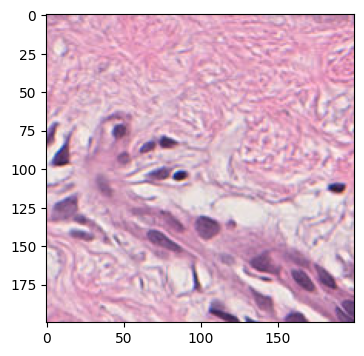

In [14]:
# Plotting
fig, ax = plt.subplots(figsize=(4, 4))

ax.imshow(im[low_x:high_x,low_y:high_y,:])

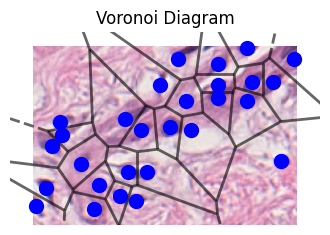

In [15]:
# Plotting
fig, ax = plt.subplots(figsize=(4, 4))

ax.imshow(im[low_x:high_x,low_y:high_y,:])
ax.set_axis_off()
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='black', line_width=2, line_alpha=0.6)

# # Plot centroids
ax.plot(centroids_subset[:, 0], centroids_subset[:, 1], 'o', color='blue', markersize=10, label='Centroids')

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_title('Voronoi Diagram')
# ax.legend()
plt.grid()
plt.show()

In [16]:
def get_voronoi_boundary(centroid_index):
    # Get the vertices that make up the region for the specified centroid
    region_index = vor.point_region[centroid_index]
    region = vor.regions[region_index]

    # Filter out vertices that are not valid (region contains -1)
    if -1 in region:
        return None  # This means the region is unbounded

    # Get the coordinates of the vertices for the region
    boundary_vertices = vor.vertices[region]
    return boundary_vertices

In [17]:
contours = []

for i,centroid in enumerate(centroids_subset):
    vertices = get_voronoi_boundary(i)
    contours.append(vertices)

threshold = 5
adjusted_contours = []
for i,contour in enumerate(contours):
    centroid = centroids_subset[i]

    out_contour = []
    if contour is None:
        continue

    for p in contour:
        vec = p - centroid
        distance = np.linalg.norm(vec)
        if distance > threshold:
            angle = np.arctan2(vec[1], vec[0])  # Angle in radians
            new_point = centroid + np.array([threshold * np.cos(angle), threshold * np.sin(angle)])
            out_contour.append(new_point)
        else:
            out_contour.append(p)
    if contour is not None:
        out_contour = np.array(out_contour)
        adjusted_contours.append(out_contour)

threshold = 20
adjusted_contours = []
for i,contour in enumerate(contours):
    centroid = centroids_subset[i]

    out_contour = []
    if contour is None:
        continue

    for p in contour:
        vec = p - centroid
        distance = np.linalg.norm(vec)
        if distance > threshold:
            angle = np.arctan2(vec[1], vec[0])  # Angle in radians
            new_point = centroid + np.array([threshold * np.cos(angle), threshold * np.sin(angle)])
            out_contour.append(new_point)
        else:
            out_contour.append(p)
    if contour is not None:
        out_contour = np.array(out_contour)
        adjusted_contours.append(out_contour)

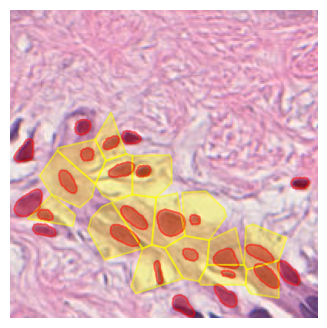

In [18]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.imshow(im[low_x:high_x,low_y:high_y,:])
ax.set_axis_off()

for polygon in adjusted_contours:
    if polygon is None:
        continue
    x_coords, y_coords = zip(*polygon)
    x_coords = list(x_coords) + [x_coords[0]]  # Close the polygon
    y_coords = list(y_coords) + [y_coords[0]]  # Close the polygon

    color = 'yellow'

    skip = False
    for x in x_coords:
        if x < 0 or x > (tile_size - 1):
            skip = True
            break
    for y in y_coords:
        if y < 0 or y > (tile_size - 1):
            skip = True
            break
    
    if not skip:

        ax.plot(x_coords, y_coords, alpha=0.3, color=color)
        ax.fill(x_coords, y_coords, alpha=0.3, color=color)  # Fill the polygon

# Plot each reversed polygon on the same image
flipped_contours = np.array([sublist[::-1] for sublist in contours_subset])

for polygon in flipped_contours:
    polygon = polygon.T
    polygon = [[x-low_x, y-low_y] for x,y in polygon]
    x_coords, y_coords = zip(*polygon)
    x_coords = list(x_coords) + [x_coords[0]]  # Close the polygon
    y_coords = list(y_coords) + [y_coords[0]]  # Close the polygon

    color = 'red'

    skip = False
    for x in x_coords:
        if x < 0 or x > (tile_size - 1):
            skip = True
            break
    for y in y_coords:
        if y < 0 or y > (tile_size - 1):
            skip = True
            break
    
    if not skip:

        ax.plot(x_coords, y_coords, alpha=0.3, color=color)
        ax.fill(x_coords, y_coords, alpha=0.3, color=color)  # Fill the polygon

Now do on the entire slide:

In [19]:
centroids = np.array([x['centroid'][0] for x in json_data])
contours = np.array([x['contour'][0] for x in json_data])


In [20]:
vor = Voronoi(centroids)

In [21]:
print(len(contours))
print(len(adjusted_contours))

13819
19


In [22]:
contours = []

for i,centroid in enumerate(centroids):
    vertices = get_voronoi_boundary(i)
    contours.append(vertices)

threshold = 5
adjusted_contours = []
for i,contour in enumerate(contours):
    centroid = centroids_subset[i]

    out_contour = []
    if contour is None:
        continue

    for p in contour:
        vec = p - centroid
        distance = np.linalg.norm(vec)
        if distance > threshold:
            angle = np.arctan2(vec[1], vec[0])  # Angle in radians
            new_point = centroid + np.array([threshold * np.cos(angle), threshold * np.sin(angle)])
            out_contour.append(new_point)
        else:
            out_contour.append(p)
    if contour is not None:
        out_contour = np.array(out_contour)
        adjusted_contours.append(out_contour)

threshold = 20
adjusted_contours = []
for i,contour in enumerate(contours):
    centroid = centroids_subset[i]

    out_contour = []
    if contour is None:
        continue

    for p in contour:
        vec = p - centroid
        distance = np.linalg.norm(vec)
        if distance > threshold:
            angle = np.arctan2(vec[1], vec[0])  # Angle in radians
            new_point = centroid + np.array([threshold * np.cos(angle), threshold * np.sin(angle)])
            out_contour.append(new_point)
        else:
            out_contour.append(p)
    if contour is not None:
        out_contour = np.array(out_contour)
        adjusted_contours.append(out_contour)

IndexError: index 28 is out of bounds for axis 0 with size 28

In [23]:
GEOdata = []

for c in adjusted_contours:
    # flip x/y coordaintes for qupath:
    c[:,[0,1]]=c[:,[1,0]]
    contour = c.tolist()
    contour.append(contour[0]) # close the polygon, needed for qupath
    
    # Create a new dictionary for each contour
    dict_data = {
        "type": "Feature",
        "id": "PathCellObject",
        "geometry": {
            "type": "Polygon",
            "coordinates": [contour]
        },
        "properties": {
            'objectType': 'annotation',
            'classification': {'name': 'Cell_contour', 'color': [97, 214, 59]}
        }
    }

    GEOdata.append(dict_data)

In [105]:
out_f = '/home/donald/Desktop/Andre_expansion/students/Donald/data/Skin_visium/lymph_spacerangerL1/binned_outputs/square_016um/iStar_data/test_on_new_slide/stardist_stuff/L0001_cell_contours.geojson'

with open(out_f, 'w') as outfile:
    geojson.dump(GEOdata, outfile)

In [30]:
GEOdata = []

for c in np.array([x['contour'][0] for x in json_data]):
    # flip x/y coordaintes for qupath:
    c = c.T
    c[:,[0,1]]=c[:,[1,0]]
    contour = c.tolist()
    contour.append(contour[0]) # close the polygon, needed for qupath
    
    # Create a new dictionary for each contour
    dict_data = {
        "type": "Feature",
        "id": "PathCellObject",
        "geometry": {
            "type": "Polygon",
            "coordinates": [contour]
        },
        "properties": {
            'objectType': 'annotation',
            'classification': {'name': 'Nuclei', 'color': [214, 214, 59]}
        }
    }

    GEOdata.append(dict_data)

In [31]:
GEOdata

[{'type': 'Feature',
  'id': 'PathCellObject',
  'geometry': {'type': 'Polygon',
   'coordinates': [[[3714.66943359375, 3088.67333984375],
     [3715.076416015625, 3087.06884765625],
     [3715.2978515625, 3085.123779296875],
     [3715.044921875, 3082.955078125],
     [3713.715576171875, 3081.446044921875],
     [3711.84619140625, 3080.71435546875],
     [3709.732666015625, 3081.28955078125],
     [3708.0, 3081.826904296875],
     [3706.520263671875, 3082.560791015625],
     [3705.3310546875, 3083.556884765625],
     [3704.21630859375, 3084.337158203125],
     [3703.396728515625, 3085.396728515625],
     [3702.364990234375, 3086.23486328125],
     [3702.099853515625, 3087.55615234375],
     [3701.811279296875, 3088.76904296875],
     [3701.45556640625, 3090.0],
     [3701.6396484375, 3091.26513671875],
     [3701.758056640625, 3092.58544921875],
     [3702.126220703125, 3093.9248046875],
     [3702.9853515625, 3095.0146484375],
     [3703.9912109375, 3095.99951171875],
     [3705.2941

In [32]:
out_f = '/home/donald/Desktop/Andre_expansion/students/Donald/data/Skin_visium/lymph_spacerangerL1/binned_outputs/square_016um/iStar_data/test_on_new_slide/stardist_stuff/L0001_nuc_contours.geojson'
with open(out_f, 'w') as outfile:
    geojson.dump(GEOdata, outfile)

(3108.6603773584907, 3087.255319148936, 3075.5079365079364, 3077.703703703704, 3087.5135135135133, 3109.959785572568)
(3702.698113207547, 3696.276595744681, 3706.5555555555557, 3721.925925925926, 3724.3783783783783, 3706.732340780369)


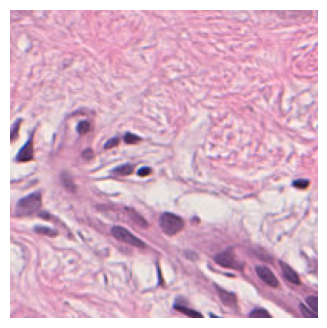

In [86]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.imshow(im[low_x:high_x,low_y:high_y,:])
ax.set_axis_off()

for polygon in adjusted_contours:
    if polygon is None:
        continue
    x_coords, y_coords = zip(*polygon)

    x_coords = list(x_coords) + [x_coords[0]]  # Close the polygon
    y_coords = list(y_coords) + [y_coords[0]]  # Close the polygon

    color = 'yellow'

    skip = False
    for x in x_coords:
        if x < 0 or x > (tile_size - 1):
            skip = True
            break
    for y in y_coords:
        if y < 0 or y > (tile_size - 1):
            skip = True
            break
    
    if not skip:

        ax.plot(x_coords, y_coords, alpha=0.3, color=color)
        ax.fill(x_coords, y_coords, alpha=0.3, color=color)  # Fill the polygon

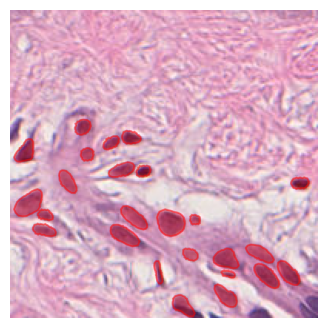

In [83]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.imshow(im[low_x:high_x,low_y:high_y,:])
ax.set_axis_off()


# Plot each reversed polygon on the same image
flipped_contours = np.array([sublist[::-1] for sublist in contours_subset])

for polygon in flipped_contours:
    polygon = polygon.T
    polygon = [[x-low_x, y-low_y] for x,y in polygon]
    x_coords, y_coords = zip(*polygon)
    x_coords = list(x_coords) + [x_coords[0]]  # Close the polygon
    y_coords = list(y_coords) + [y_coords[0]]  # Close the polygon

    color = 'red'

    skip = False
    for x in x_coords:
        if x < 0 or x > (tile_size - 1):
            skip = True
            break
    for y in y_coords:
        if y < 0 or y > (tile_size - 1):
            skip = True
            break
    
    if not skip:

        ax.plot(x_coords, y_coords, alpha=0.3, color=color)
        ax.fill(x_coords, y_coords, alpha=0.3, color=color)  # Fill the polygon